In [1]:
import codecs
import errno
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.datasets.mnist
from torchvision import transforms
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [4]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
    assert get_int(data[:4]) == 2049
    length = get_int(data[4:8])
    parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
    return torch.from_numpy(parsed).view(length).long()

In [5]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
    assert get_int(data[:4]) == 2051
    length = get_int(data[4:8])
    num_rows = get_int(data[8:12])
    num_cols = get_int(data[12:16])
    images = []
    parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
    return torch.from_numpy(parsed).view(length, num_rows, num_cols)

In [6]:
class MNISTPairs(torch.utils.data.Dataset):
    raw_folder = 'MNIST/raw'
    processed_folder = 'MNIST/processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train # training set or test set

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))

            train_labels_class = []
            train_data_class = []
            for i in range(10):
                indices = torch.squeeze((self.train_labels == i).nonzero())
                train_labels_class.append(torch.index_select(self.train_labels, 0, indices))
                train_data_class.append(torch.index_select(self.train_data, 0, indices))

            # generate balanced pairs
            self.train_data = []
            self.train_labels = []
            lengths = [x.shape[0] for x in train_labels_class]
            for i in range(10):
                for j in range(500): # create 500 pairs
                    rnd_cls = random.randint(0,8) # choose random class that is not the same class
                    if rnd_cls >= i:
                        rnd_cls = rnd_cls + 1

                    rnd_dist = random.randint(0, 100)

                    self.train_data.append(torch.stack([train_data_class[i][j], train_data_class[i][j+rnd_dist], train_data_class[rnd_cls][j]]))
                    self.train_labels.append([1,0])

            self.train_data = torch.stack(self.train_data)
            self.train_labels = torch.tensor(self.train_labels)

        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))

            test_labels_class = []
            test_data_class = []
            for i in range(10):
                indices = torch.squeeze((self.test_labels == i).nonzero())
                test_labels_class.append(torch.index_select(self.test_labels, 0, indices))
                test_data_class.append(torch.index_select(self.test_data, 0, indices))

            # generate balanced pairs
            self.test_data = []
            self.test_labels = []
            lengths = [x.shape[0] for x in test_labels_class]
            for i in range(10):
                for j in range(500): # create 500 pairs
                    rnd_cls = random.randint(0,8) # choose random class that is not the same class
                    if rnd_cls >= i:
                        rnd_cls = rnd_cls + 1

                    rnd_dist = random.randint(0, 100)

                    self.test_data.append(torch.stack([test_data_class[i][j], test_data_class[i][j+rnd_dist], test_data_class[rnd_cls][j]]))
                    self.test_labels.append([1,0])

            self.test_data = torch.stack(self.test_data)
            self.test_labels = torch.tensor(self.test_labels)

    def __getitem__(self, index):
        if self.train:
            imgs, target = self.train_data[index], self.train_labels[index]
        else:
            imgs, target = self.test_data[index], self.test_labels[index]

        img_ar = []
        for i in range(len(imgs)):
            img = Image.fromarray(imgs[i].numpy(), mode='L')
            if self.transform is not None:
                img = self.transform(img)
            img_ar.append(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img_ar, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

In [69]:
class DiffNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(512, 2)
    def forward(self, emb1, emb2):
        res = torch.abs(emb2 - emb1)
        res = self.linear(res)
        return res

In [75]:
class Net(nn.Module):
    def __init__(self,diffnet):
        super(Net,self).__init__()
        self.diffnet = diffnet
        self.conv1 = nn.Conv2d(1, 64, 7)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.linear1 = nn.Linear(2304, 512)
        self.linear2 = nn.Linear(512, 512)
    def get_embedding(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = F.relu(x)
        return x
    def forward_from_embedding(self, emb1, emb2):
        res = self.diffnet(emb1,emb2)
        return res

    def forward(self, data):
        res = []
        for i in range(2): # Siamese nets; sharing weights
            x = data[i]
            x = self.conv1(x)
            x = F.relu(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = self.conv3(x)
            x = F.relu(x)

            x = x.view(x.shape[0], -1)
            x = F.relu(self.linear1(x))
            x = self.linear2(x)
            x = F.relu(x)
            res.append(x)

        res = self.diffnet(res[0],res[1])
        return res
   

In [41]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward_dist_label(self, dist, label):
        loss = torch.mean(1/2*(label) * torch.pow(dist, 2) +
                                      1/2*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))


        return loss
    def forward(self, anchor, positive, negative, op_p, op_n, t_p, t_n):
        dist1 = F.pairwise_distance(anchor,positive)
#         dist1 = (anchor - positive).pow(2).sum(1)
        label1 = t_p
        
        dist2 = F.pairwise_distance(anchor,negative)
#         dist2 = (anchor - negative).pow(2).sum(1)
        label2 = t_n
        
        loss = self.forward_dist_label(dist1,label1) + self.forward_dist_label(dist2,label2)
        return loss

In [42]:
class TripletLoss(torch.nn.Module):
    """
    Triplet loss function.
    """

    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, op_p, op_n, t_p, t_n):

#         squarred_distance_1 = torch.norm(anchor-positive,dim=1)
        
#         squarred_distance_2 = torch.norm(anchor-negative,dim=1)

        squarred_distance_1 = (anchor - positive).pow(2).sum(1)
        
        squarred_distance_2 = (anchor - negative).pow(2).sum(1)
        
        triplet_loss = F.relu( self.margin + squarred_distance_1 - squarred_distance_2 ).mean()
        
        return triplet_loss

In [43]:
class CrossEntLoss(torch.nn.Module):
    """
    Cross Entropy loss function.
    """

    def __init__(self):
        super(CrossEntLoss, self).__init__()

    def forward(self, anchor, positive, negative, op_p, op_n, t_p, t_n):

        loss_positive = F.cross_entropy(op_p, t_p)
        loss_negative = F.cross_entropy(op_n, t_n)
        loss = loss_positive + loss_negative
        
        return loss

In [78]:
def train(model, diffnet, device, train_loader, epoch, optimizer, optimizer2, loss_fn):
    model.train()
    diffnet.train()
    curr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        
        optimizer.zero_grad()
        embedding_anchor = model.get_embedding(data[0])
        embedding_positive = model.get_embedding(data[1])
        embedding_negative = model.get_embedding(data[2])
        
        output_positive = diffnet(embedding_anchor, embedding_positive)
        output_negative = diffnet(embedding_anchor, embedding_negative)
#         output_positive = model([data[0], data[1]])
#         output_negative = model([data[0], data[2]])

        target = target.type(torch.LongTensor).to(device)
        target_positive = torch.squeeze(target[:,0])
        target_negative = torch.squeeze(target[:,1])

#         loss_positive = F.cross_entropy(output_positive, target_positive)
#         loss_negative = F.cross_entropy(output_negative, target_negative)
#         loss = loss_positive + loss_negative
        
        loss = loss_fn(embedding_anchor,embedding_positive,embedding_negative,
                       output_positive,output_negative, target_positive, target_negative)


        
        loss.backward()
        optimizer.step()
        
        optimizer2.zero_grad()
        output_positive = diffnet(embedding_anchor.data,embedding_positive.data)
        output_negative = diffnet(embedding_anchor.data,embedding_negative.data)
        loss2 = F.cross_entropy(output_positive, target_positive) + F.cross_entropy(output_negative, target_negative)
        loss2.backward()
        optimizer2.step()
        
        
        
        
        curr_loss += loss.item()
        
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1)*batch_size, len(train_loader.dataset), 100. * (batch_idx+1)*batch_size / len(train_loader.dataset),
                curr_loss*1.0/((batch_idx+1)*batch_size)),end='\t\t\t')
    print('')

In [81]:
def test(model, diffnet, device, test_loader, loss_fn):
    model.eval()
    
    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            
            embedding_anchor = model.get_embedding(data[0])
            embedding_positive = model.get_embedding(data[1])
            embedding_negative = model.get_embedding(data[2])

            output_positive = diffnet(embedding_anchor, embedding_positive)
            output_negative = diffnet(embedding_anchor, embedding_negative)
#             output_positive = model([data[0], data[1]])
#             output_negative = model([data[0], data[2]])

            target = target.type(torch.LongTensor).to(device)
            target_positive = torch.squeeze(target[:,0])
            target_negative = torch.squeeze(target[:,1])

#             loss_positive = F.cross_entropy(output_positive, target_positive)
#             loss_negative = F.cross_entropy(output_negative, target_negative)

#             loss += loss_positive + loss_negative

            loss += loss_fn(embedding_anchor,embedding_positive,embedding_negative,
                           output_positive, output_negative, target_positive, target_negative)
    
            accurate_labels_positive = torch.sum(torch.argmax(output_positive, dim=1) == target_positive).cpu()
            accurate_labels_negative = torch.sum(torch.argmax(output_negative, dim=1) == target_negative).cpu()

            accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
            all_labels = all_labels + len(target_positive) + len(target_negative)

        accuracy = 100. * accurate_labels / all_labels
        print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss/all_labels))
#         print('Test Loss: {:.6f}'.format(loss/all_labels))
   

In [96]:
def oneshot(model, diffnet, device, data):
    model.eval()
    diffnet.eval()
    with torch.no_grad():
        for i in range(len(data)):
            data[i] = data[i].to(device)
        out1 = model.get_embedding(data[0])
        out2 = model.get_embedding(data[1])
        output = diffnet(out1,out2)
        return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

In [65]:
batch_size = 20


In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [67]:
train_loader = torch.utils.data.DataLoader(MNISTPairs('~/.pytorch/MNIST/', train=True, transform=trans), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNISTPairs('~/.pytorch/MNIST/', train=False, transform=trans), batch_size=batch_size, shuffle=False)

### Contrastive Loss

In [84]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.001
num_epochs = 10
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.Adam(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = ContrastiveLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.022719			
Test accuracy: 9197/10000 (91.970%)	Loss: 0.007307
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.008628			
Test accuracy: 9575/10000 (95.750%)	Loss: 0.004752
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.004560			
Test accuracy: 9594/10000 (95.940%)	Loss: 0.003922
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.002469								
Test accuracy: 9602/10000 (96.020%)	Loss: 0.003743
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.001510			
Test accuracy: 9673/10000 (96.730%)	Loss: 0.003177
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.001123			
Test accuracy: 9670/10000 (96.700%)	Loss: 0.002798
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.000814					
Test accuracy: 9727/10000 (97.270%)	Loss: 0.002393
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.000705				
Test accuracy: 9574/10000 (95.740%)	Loss: 0.003858
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.001108						
Test accuracy: 9629/10000 (96.290%)	Loss: 0.003662
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.000854					
Test acc

In [99]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.001
num_epochs = 20
weight_decay = 1e-6

optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.RMSprop(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = ContrastiveLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 10.101742			
Test accuracy: 5826/10000 (58.260%)	Loss: 0.026652
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.051721			
Test accuracy: 6167/10000 (61.670%)	Loss: 0.024067
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.043309			
Test accuracy: 6711/10000 (67.110%)	Loss: 0.019698
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.035721			
Test accuracy: 7722/10000 (77.220%)	Loss: 0.015684
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.027921			
Test accuracy: 8065/10000 (80.650%)	Loss: 0.013545
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.024074			
Test accuracy: 8445/10000 (84.450%)	Loss: 0.012242
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.018997			
Test accuracy: 8821/10000 (88.210%)	Loss: 0.009812
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.013971			
Test accuracy: 9027/10000 (90.270%)	Loss: 0.008740
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.009617			
Test accuracy: 9142/10000 (91.420%)	Loss: 0.007081
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.006249			
Test accuracy: 9163/

In [101]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.1
num_epochs = 20
weight_decay = 1e-6

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.SGD(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = ContrastiveLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.024764			
Test accuracy: 8712/10000 (87.120%)	Loss: 0.007680
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.010342			
Test accuracy: 9479/10000 (94.790%)	Loss: 0.005001
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.006145			
Test accuracy: 9573/10000 (95.730%)	Loss: 0.004206
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.004153			
Test accuracy: 9735/10000 (97.350%)	Loss: 0.003152
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.002890			
Test accuracy: 9772/10000 (97.720%)	Loss: 0.002805
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.002037			
Test accuracy: 9764/10000 (97.640%)	Loss: 0.002616
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.001434			
Test accuracy: 9750/10000 (97.500%)	Loss: 0.002553
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.001026			
Test accuracy: 9737/10000 (97.370%)	Loss: 0.002559
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.000816			
Test accuracy: 9729/10000 (97.290%)	Loss: 0.002501
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.000580			
Test accuracy: 9750/1

### Triplet Loss

In [104]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.001
num_epochs = 15
weight_decay = 1e-4

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.Adam(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = TripletLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.039015			
Test accuracy: 7977/10000 (79.770%)	Loss: 0.013628
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.021679			
Test accuracy: 8649/10000 (86.490%)	Loss: 0.007936
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.012866			
Test accuracy: 8643/10000 (86.430%)	Loss: 0.009263
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.007842			
Test accuracy: 8955/10000 (89.550%)	Loss: 0.005655
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.005465			
Test accuracy: 8995/10000 (89.950%)	Loss: 0.005945
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.006890			
Test accuracy: 9130/10000 (91.300%)	Loss: 0.003907
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.003036			
Test accuracy: 8557/10000 (85.570%)	Loss: 0.008241
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.004518			
Test accuracy: 9080/10000 (90.800%)	Loss: 0.004053
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.002544			
Test accuracy: 9221/10000 (92.210%)	Loss: 0.003867
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.002026			
Test accuracy: 9348/1

In [105]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.001
num_epochs = 15
weight_decay = 1e-4

optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.RMSprop(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = TripletLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.362484			
Test accuracy: 7045/10000 (70.450%)	Loss: 0.034241
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.040159			
Test accuracy: 7431/10000 (74.310%)	Loss: 0.023254
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.036623			
Test accuracy: 7924/10000 (79.240%)	Loss: 0.014214
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.023953			
Test accuracy: 8492/10000 (84.920%)	Loss: 0.009547
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.025232			
Test accuracy: 7231/10000 (72.310%)	Loss: 0.024949
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.016236			
Test accuracy: 8366/10000 (83.660%)	Loss: 0.011879
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.010804			
Test accuracy: 9153/10000 (91.530%)	Loss: 0.005326
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.009599			
Test accuracy: 8826/10000 (88.260%)	Loss: 0.006891
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.007982			
Test accuracy: 9124/10000 (91.240%)	Loss: 0.006533
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.007442			
Test accuracy: 9177/1

In [107]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.1
num_epochs = 20
weight_decay = 1e-6

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.SGD(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = TripletLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.089908			
Test accuracy: 6364/10000 (63.640%)	Loss: 0.036409
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.038660			
Test accuracy: 7883/10000 (78.830%)	Loss: 0.013033
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.015324			
Test accuracy: 8754/10000 (87.540%)	Loss: 0.006955
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.007559			
Test accuracy: 8740/10000 (87.400%)	Loss: 0.008350
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.006200			
Test accuracy: 8715/10000 (87.150%)	Loss: 0.008283
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.003912			
Test accuracy: 9163/10000 (91.630%)	Loss: 0.004131
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.002471			
Test accuracy: 9232/10000 (92.320%)	Loss: 0.004217
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.002708			
Test accuracy: 9298/10000 (92.980%)	Loss: 0.003720
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.002026			
Test accuracy: 9291/10000 (92.910%)	Loss: 0.003644
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.001564			
Test accuracy: 9101/1

### Cross Entropy Loss

In [97]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.001
num_epochs = 10
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.Adam(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = CrossEntLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.041965			
Test accuracy: 8945/10000 (89.450%)	Loss: 0.013701
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.018692			
Test accuracy: 9455/10000 (94.550%)	Loss: 0.007590
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.008346			
Test accuracy: 9523/10000 (95.230%)	Loss: 0.007134
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.005229			
Test accuracy: 9576/10000 (95.760%)	Loss: 0.006094
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.003980			
Test accuracy: 9643/10000 (96.430%)	Loss: 0.005126
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.002906			
Test accuracy: 9492/10000 (94.920%)	Loss: 0.007216
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.001797			
Test accuracy: 9602/10000 (96.020%)	Loss: 0.006493
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.000726			
Test accuracy: 9611/10000 (96.110%)	Loss: 0.007618
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.002747			
Test accuracy: 9405/10000 (94.050%)	Loss: 0.010278
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.002087			
Test accuracy: 9649/1

In [109]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.001
num_epochs = 20
weight_decay = 1e-6

optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.RMSprop(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = CrossEntLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.214392			
Test accuracy: 7961/10000 (79.610%)	Loss: 0.022513
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.037502			
Test accuracy: 8524/10000 (85.240%)	Loss: 0.017401
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.029639			
Test accuracy: 8756/10000 (87.560%)	Loss: 0.015108
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.023023			
Test accuracy: 9022/10000 (90.220%)	Loss: 0.011641
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.017402			
Test accuracy: 9203/10000 (92.030%)	Loss: 0.010449
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.013319			
Test accuracy: 9301/10000 (93.010%)	Loss: 0.009136
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.008708			
Test accuracy: 9459/10000 (94.590%)	Loss: 0.007664
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.008169			
Test accuracy: 9451/10000 (94.510%)	Loss: 0.007528
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.005251			
Test accuracy: 9490/10000 (94.900%)	Loss: 0.007813
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.005577			
Test accuracy: 9522/1

In [110]:
# embedding_net = EmbeddingNet().to(device)
diffnet = DiffNet().to(device)
model = Net(diffnet).to(device)

lr = 0.1
num_epochs = 20
weight_decay = 1e-6

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
optim2 = optim.SGD(diffnet.parameters(), lr=0.01, weight_decay=weight_decay)
loss_fn = CrossEntLoss()
for epoch in range(num_epochs):
    train(model, diffnet, device, train_loader, epoch, optimizer, optim2,loss_fn)
    test(model, diffnet, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.052443			
Test accuracy: 8803/10000 (88.030%)	Loss: 0.015094
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.023354			
Test accuracy: 9348/10000 (93.480%)	Loss: 0.008459
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.010240			
Test accuracy: 9391/10000 (93.910%)	Loss: 0.008779
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.005696			
Test accuracy: 9629/10000 (96.290%)	Loss: 0.005070
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.003205			
Test accuracy: 9595/10000 (95.950%)	Loss: 0.005497
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.001867			
Test accuracy: 9699/10000 (96.990%)	Loss: 0.004434
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.001507			
Test accuracy: 9704/10000 (97.040%)	Loss: 0.004278
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.000459			
Test accuracy: 9766/10000 (97.660%)	Loss: 0.003878
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.000226			
Test accuracy: 9753/10000 (97.530%)	Loss: 0.004444
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.000065			
Test accuracy: 9750/1

### Sample

In [111]:
from matplotlib import pyplot as plt

In [113]:
prediction_loader = torch.utils.data.DataLoader(MNISTPairs('~/.pytorch/MNIST/', train=False, transform=trans), batch_size=1, shuffle=True)

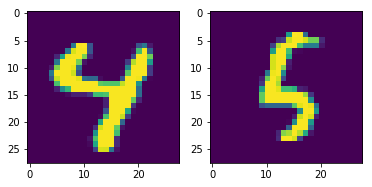

These two images are not of the same number


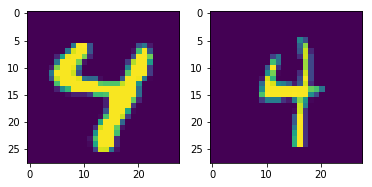

These two images are of the same number


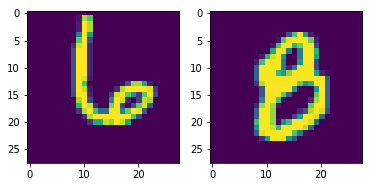

These two images are not of the same number


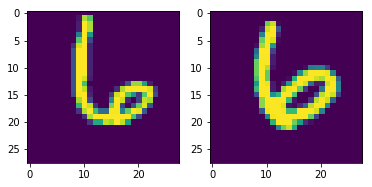

These two images are of the same number


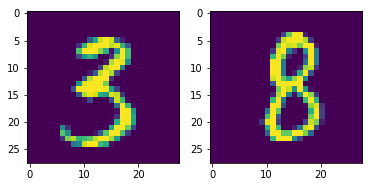

These two images are not of the same number


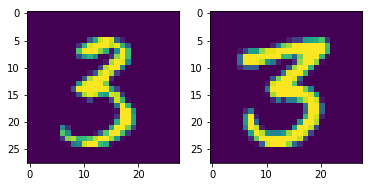

These two images are of the same number


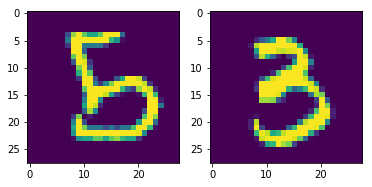

These two images are not of the same number


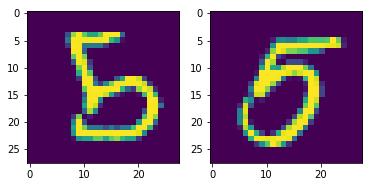

These two images are not of the same number


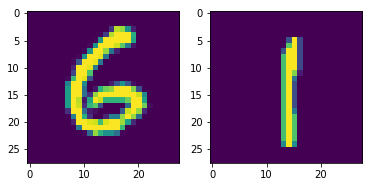

These two images are not of the same number


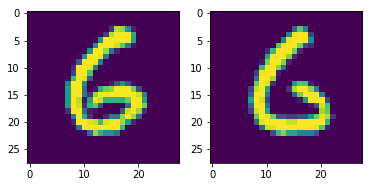

These two images are of the same number


In [114]:
for i in range(5):
    triplets = next(iter(prediction_loader))

    data = []
    data.extend(triplets[0][:3:2])
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(data[0].numpy()[0,0])
    axes[1].imshow(data[1].numpy()[0,0])
    plt.show()
    same = oneshot(model, diffnet, device, data)
    if same > 0:
        print('These two images are of the same number')
    else:
        print('These two images are not of the same number')

    data = []
    data.extend(triplets[0][:2])
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(data[0].numpy()[0,0])
    axes[1].imshow(data[1].numpy()[0,0])
    plt.show()
    same = oneshot(model, diffnet, device, data)
    if same > 0:
        print('These two images are of the same number')
    else:
        print('These two images are not of the same number')

## Comparison of results

|         |  contrastive loss | triplet loss | cross entropy |
|---------|-------------------|--------------|---------------|
|  Adam   |    97.50%         |     93.29%   |  96.49%       |
| RMSprop |    96.60%         |     93.07%   |  94.46%       |
|  SGD    |    97.49%         |     94.51%   |  97.38%       |

Adam works best for high accuracy. This is because Adam maintains a per-parameter learning rate that improves performance on problems with sparse gradients.

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

RMSprop also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight. This means the algorithm does well on online and non-stationary problem.

## Experiments on Hyper parameters

### Weight decay:
Increasing the weight decay decreases learning per epoch, however too low weight decay makes the model susceptible to overfiting and getting into local minimas.
Tried weight decays: 1e-3, 1e-4, 1e-5, 1e-6

### Learning Rate:
Too high learning rate makes the loss unstable and this is also one of the ways you find that your learning rate is too high.
Too low learning rate makes the learning very slow.

Tried learning rates: 0.1, 0.01, 0.005, 0.0015, 0.001, 0.0001

## Pros and Cons of Siamese Network

### Pros:
1. **More Robust to class Imbalance**: With the aid of One-shot learning, given a few images per class is sufficient for Siamese Networks to recognize those images in the future
2. **Nice to an ensemble with the best classifier**: Given that its learning mechanism is somewhat different from Classification, simple averaging of it with a Classifier can do much better than average 2 correlated Supervised models (e.g. GBM & RF classifier)
3. **Learning from Semantic Similarity**: Siamese focuses on learning embeddings (in the deeper layer) that place the same classes/concepts close together. Hence, can learn semantic similarity.

### Cons:
1. **Needs more training time than normal networks**: Since Siamese Networks involves quadratic pairs to learn from (to see all information available) it is slower than normal classification type of learning(pointwise learning)
2. **Doesn’t output probabilities**: Since training involves pairwise learning, it won’t output the probabilities of the prediction, but the distance from each class

